# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [102]:
import pandas as pd
import numpy as np
import math
import json

import seaborn as sns
sns.set(style = 'whitegrid')

from datetime import datetime

from sklearn import preprocessing
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
import tensorflow as tf
import keras
import time

import matplotlib.pyplot as plt
% matplotlib inline

In [103]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [104]:
#show portfolio dataset
portfolio

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


In [105]:
# Shape of portfolio dataset
portfolio.shape

(10, 6)

In [106]:
# Calculate the null values in portfolio dataset
portfolio.isnull().sum()

channels      0
difficulty    0
duration      0
id            0
offer_type    0
reward        0
dtype: int64

We do not have missing or null values in portflio dataset

In [107]:
# Find out the number of unique offers in portfolio dataset
portfolio['id'].nunique()

10

Both the number of rows in the portfolio dataset and unique offers in the portfolio dataset are '10'.  

In [108]:
# Find out the type of unique offers
portfolio['offer_type'].unique()

array(['bogo', 'informational', 'discount'], dtype=object)

In [109]:
print(f"There are {portfolio['id'].nunique()} unique offers in the portfolio.")
print("These are distributed among the offer types as follows")
portfolio.offer_type.value_counts()

There are 10 unique offers in the portfolio.
These are distributed among the offer types as follows


bogo             4
discount         4
informational    2
Name: offer_type, dtype: int64

In [110]:
def clean_portfolio(portfolio):
    
    '''
    data cleaning the portfolio dataframe
    
    INPUT:
    portfolio - the portfolio dataframe to be cleaned
    
    OUTPUT:
    portfolio - the cleaned portfolio dataframe
    
    '''
    
    # Change name of feature id to offer_id
    portfolio.rename(columns={'id': 'offer_id'}, inplace=True)

    # change the duration from day to hour
    clean_portfolio = portfolio.copy()
    clean_portfolio['duration'] = clean_portfolio['duration'] * 24
    
    # apply one hot encoding to channels culumn
    
    channels=clean_portfolio['channels'].map(lambda x: ','.join(map(str, x))).str.get_dummies(sep=',')
    
    
    # apply one hot encoding to offer_type column
    offer_type = pd.get_dummies(clean_portfolio['offer_type'])
    
    # drop the culumns channels and offer_type 
    clean_portfolio.drop(['channels', 'offer_type'], axis=1, inplace=True)
    
    # combine the dataframe clean_portfolio and offer_type to form a cleaned dataframe
    clean_portfolio = pd.concat([clean_portfolio, channels, offer_type], axis=1, sort=False)
    
    return clean_portfolio

In [111]:
clean_portfolio=clean_portfolio(portfolio)

In [112]:
# Show clean_portfolio dataset
clean_portfolio.head()

,difficulty,duration,offer_id,reward,email,mobile,social,web,bogo,discount,informational
0,10,168,ae264e3637204a6fb9bb56bc8210ddfd,10,1,1,1,0,1,0,0
1,10,120,4d5c57ea9a6940dd891ad53e9dbe8da0,10,1,1,1,1,1,0,0
2,0,96,3f207df678b143eea3cee63160fa8bed,0,1,1,0,1,0,0,1
3,5,168,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,1,1,0,1,1,0,0
4,20,240,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,1,0,0,1,0,1,0


# Profile Data 

In [113]:
# Show profile dataset
profile

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN
5,68,20180426,M,e2127556f4f64592b11af22de27a7932,70000.0
6,118,20170925,None,8ec6ce2a7e7949b1bf142def7d0e0586,NaN
7,118,20171002,None,68617ca6246f4fbc85e91a2a49552598,NaN
8,65,20180209,M,389bc3fa690240e798340f5a15918d5c,53000.0
9,118,20161122,None,8974fc5686fe429db53ddde067b88302,NaN


In [114]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


There are NaN (or missing) values in the 'income' column.

In [115]:
# Number of missing values in profile data set
profile.isnull().sum()

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

Only the 'gender' and 'income' columns of the profile data set contain missing values. It seems as if some users were not comfortable revealing their gender and income information, and they declined to answer. 

Note that the total number of missing values in both gender and income are 2175.

In [116]:
# Shape of profile data set
profile.shape

(17000, 5)

There are 17000 rows and 5 columns in the profile dataframe.

In [117]:
# percentage of missing values
profile.isnull().sum()*100/len(profile)

age                  0.000000
became_member_on     0.000000
gender              12.794118
id                   0.000000
income              12.794118
dtype: float64

There are 12.794118 percent missing values in the profile dataframe. Overall, the quality of data is not bad!

In [118]:
(profile[(profile['gender'].isna()) & (profile['income'].isna())]).head(7)

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN
6,118,20170925,None,8ec6ce2a7e7949b1bf142def7d0e0586,NaN
7,118,20171002,None,68617ca6246f4fbc85e91a2a49552598,NaN
9,118,20161122,None,8974fc5686fe429db53ddde067b88302,NaN
10,118,20170824,None,c4863c7985cf408faee930f111475da3,NaN


The 'became_member_on' column is messy and we do not need it for or analysis. The profile data frame will look more realistic after cleaning. 

The missing values in gender and income column are not useful. Dropping missing values will not affect our analysis and it can be useful during model builing stage.

In [119]:
# Drop missing values
# Modify profile data frame
profile.dropna(inplace=True)

(array([0, 1, 2]), <a list of 3 Text xticklabel objects>)

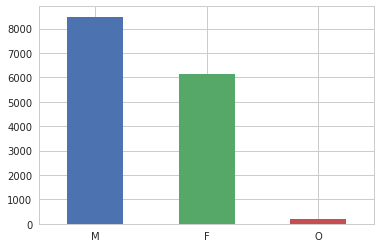

In [120]:
# Plot gender distribution in the profile data frame
(profile['gender'].value_counts()).plot(kind='bar')
plt.xticks(rotation=0)

In [121]:
# calculate the number of unique profiles in dataset
profile.id.nunique()

14825

In [122]:
# Calculate count of unique age
profile['age'].value_counts().sort_index(ascending=False)

101      5
100     12
99       5
98       5
97      13
96       8
95      22
94      33
93      29
92      40
91      47
90      52
89      53
88      64
87      66
86      54
85      70
84      83
83     102
82     105
81     118
80     116
79     117
78     135
77     141
76     155
75     159
74     193
73     209
72     191
      ... 
47     232
46     212
45     231
44     192
43     215
42     227
41     189
40     202
39     182
38     172
37     197
36     175
35     118
34     147
33     152
32     139
31     113
30     131
29     129
28     137
27     139
26     157
25     136
24     139
23     126
22     131
21     140
20     135
19     135
18      70
Name: age, Length: 84, dtype: int64

It can be oberserved from above that the mximum 'age' of the users is 101. There are only 5 obserrvations with the maax age 101. There are, however, 12 profiles of the age 100 which is the second highest age. There are 5 profiles of age 99 which is the third highest age. 

In [123]:
# View records of profile dataframe for age 100
profile_100 = profile[profile['age'] == 100]
profile_100.head(10)

,age,became_member_on,gender,id,income
283,100,20150828,F,24c1287eb7a84cfd80472a82e05b1d57,63000.0
1171,100,20170905,F,28bbebb2b76f4057b1115dd80441e37a,118000.0
1612,100,20180123,F,857fc6e18cf74f7b8ebce26bbfbd3028,109000.0
4277,100,20150911,M,b12e8e0f14ae4ad0b576f7c016e7e89b,98000.0
6061,100,20180410,F,9b675a966bd040eeac75f9aa01b14773,70000.0
6902,100,20171231,F,85f4e5ea5c0044619482bfe16ae32c01,71000.0
7129,100,20171126,F,be79870ff776461d97e1aee515269644,47000.0
10939,100,20160629,O,9eb812054d564bdba180dc365f186e23,83000.0
13120,100,20170507,F,edbb23d321174301a15049a09df4072b,71000.0
15164,100,20180330,F,3b34370727654cfca5322bca2aba9ffd,96000.0


Text(0.5,1,'Distribution of age counts')

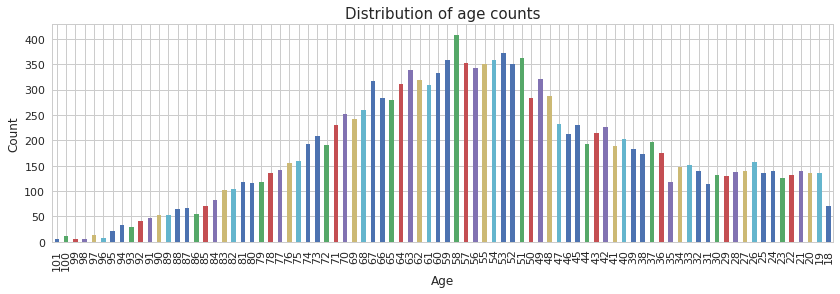

In [124]:
# Plot distribution of ages in profile dataframe 
profile['age'].value_counts().sort_index(ascending=False).plot.bar(figsize=(14,4), fontsize=11);
plt.xlabel('Age', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Distribution of age counts', fontsize=15)

In [125]:
profile.head(10)

,age,became_member_on,gender,id,income
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
5,68,20180426,M,e2127556f4f64592b11af22de27a7932,70000.0
8,65,20180209,M,389bc3fa690240e798340f5a15918d5c,53000.0
12,58,20171111,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0
13,61,20170911,F,aa4862eba776480b8bb9c68455b8c2e1,57000.0
14,26,20140213,M,e12aeaf2d47d42479ea1c4ac3d8286c6,46000.0
15,62,20160211,F,31dda685af34476cad5bc968bdb01c53,71000.0
16,49,20141113,M,62cf5e10845442329191fc246e7bcea3,52000.0
18,57,20171231,M,6445de3b47274c759400cd68131d91b4,42000.0


The date time of the became_member_on column does not look good.

In [126]:
profile.dtypes

age                   int64
became_member_on      int64
gender               object
id                   object
income              float64
dtype: object

In [127]:
profile = profile.rename(columns = {'id': 'customer_id'})

In [128]:
profile.head(5)

,age,became_member_on,gender,customer_id,income
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
5,68,20180426,M,e2127556f4f64592b11af22de27a7932,70000.0
8,65,20180209,M,389bc3fa690240e798340f5a15918d5c,53000.0
12,58,20171111,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0


The distribution plot of their income, and age based on their genders needs to be explored and visualized. for this, can write a function plot_profile() to reduce repeating code of writing 3 times.

In [129]:
def plot_profile(df, variable):
    '''
    returns a basic histogram and density plot for demographic variables
    
    INPUT:
    df - the dataframe including the variable to be plotted
    variable - the variable to be plotted
    
    OUTPUT:
    plt - basic histogram and density plot
    
    ''' 
    sns.set(style = 'whitegrid', font_scale = 1.25)
    palette = sns.color_palette()
    fig, ax = plt.subplots(figsize=(20,4), nrows = 1, ncols = 3, sharex = True, sharey = True)
    
    plt.sca(ax[0])
    sns.distplot(df[df['gender'] == 'F'][variable], bins = 10, color = palette[0]);
    plt.title('Female\'s {} distribution'.format(variable))
    plt.xlabel(f'{variable}')
    plt.ylabel('Distribution')

    plt.sca(ax[1])
    sns.distplot(df[df['gender'] == 'M'][variable], bins = 10, color = palette[1]);
    plt.title('Male\'s {} distribution'.format(variable))
    plt.xlabel(f'{variable}')

    plt.sca(ax[2])
    sns.distplot(df[df['gender'] == 'O'][variable], bins = 10, color = palette[2]);
    plt.title('Other\'s {} distribution'.format(variable))
    plt.xlabel(f'{variable}')
    plt.show()
    
    return plt

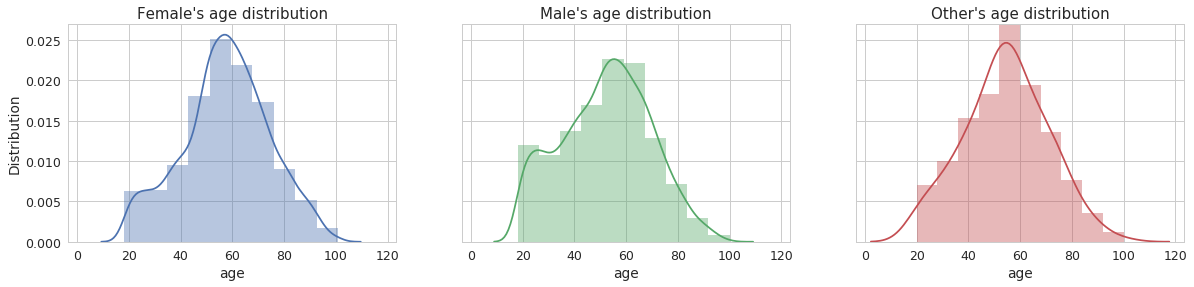

In [130]:
age_plot = plot_profile(profile, 'age')

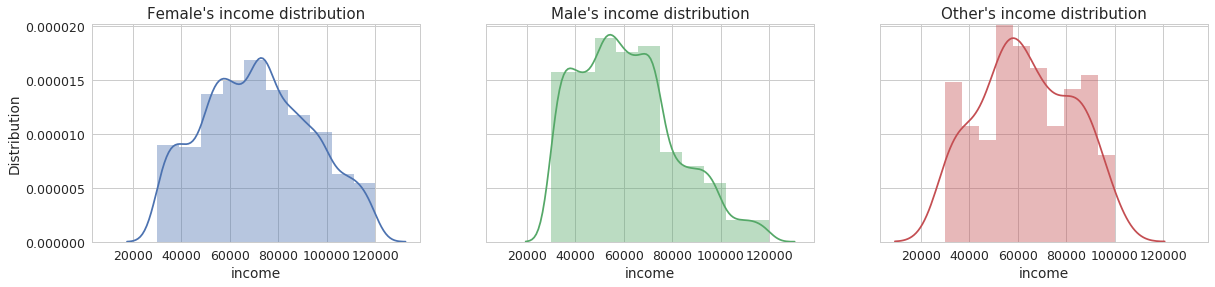

In [131]:
income_plot = plot_profile(profile, 'income')

# Transcript data - events

In [132]:
transcript.head(7)

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}
5,offer received,389bc3fa690240e798340f5a15918d5c,0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
6,offer received,c4863c7985cf408faee930f111475da3,0,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}


In [133]:
# unique events types
transcript['event'].unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'], dtype=object)

In [134]:
# number of each events
transcript['event'].value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

In [135]:
len(transcript)

306534

In [136]:
# Calculate null values in transaction dataframe
transcript.isnull().sum()

event     0
person    0
time      0
value     0
dtype: int64

The transcript data frame has no missing values

In [137]:
# Print shape of transcript dataframe
transcript.shape

(306534, 4)

In [138]:
# calculate number of observations in transcript of cunsomers having age 100
id_age_100 = profile_100['id'].unique().tolist()
transcript['person'].isin(id_age_100).value_counts()

False    306300
True        234
Name: person, dtype: int64

In the section of cleaning profile dataset, I found that there are 12 customers with age 100. It is intersting for the analysis purpose.

In [139]:
# Print features of transcript dataframe
transcript.columns

Index(['event', 'person', 'time', 'value'], dtype='object')

In [140]:
def clean_trascript(transcript):
    
    '''
    data cleaning the transcript dataframe
    
    INPUT:
    transcript - the transcript dataframe to be cleaned
    
    OUTPUT:
    transcript - the cleaned transcript dataframe
    
    '''
    # copy dataframe from transcript to clean_transcript
    clean_transcript = transcript.copy()
    
    # Change name of feature person to customer_id in transcript dataframe
    clean_transcript.rename(columns={'person': 'customer_id'}, inplace=True)    
    
    return clean_transcript

In [141]:
clean_transcript=clean_trascript(transcript)

In [142]:
clean_transcript.head()

,event,customer_id,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [143]:
# the percentage of unique values in event feature
round((transcript['event'].value_counts()/transcript['event'].value_counts().sum())*100,2)

transaction        45.33
offer received     24.88
offer viewed       18.83
offer completed    10.95
Name: event, dtype: float64

In [144]:
# Create dataframe offers_df containing only offers events and transaction_df containing only transaction event
# Create a list of offer event types
offer_event_list = ['offer received', 'offer viewed', 'offer completed']

# Find index where feature 'event' is 'offer received', 'offer viewed', 'offer completed'
offer_index = clean_transcript[clean_transcript['event'].isin(offer_event_list)].index

# Find index where feature event is 'transaction'
transaction_index = clean_transcript[~clean_transcript['event'].isin(offer_event_list)].index

# Create offers_df
offers_df = clean_transcript.loc[offer_index,:]

# Create transaction_df
transaction_df = clean_transcript.loc[transaction_index,:]

In [145]:
# show the dataframe offers_df
offers_df.head()

,event,customer_id,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [146]:
# show the dataframe offers_df
transaction_df.head()

,event,customer_id,time,value
12654,transaction,02c083884c7d45b39cc68e1314fec56c,0,{'amount': 0.8300000000000001}
12657,transaction,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,{'amount': 34.56}
12659,transaction,54890f68699049c2a04d415abc25e717,0,{'amount': 13.23}
12670,transaction,b2f1cd155b864803ad8334cdf13c4bd2,0,{'amount': 19.51}
12671,transaction,fe97aa22dd3e48c8b143116a8403dd52,0,{'amount': 18.97}


In [147]:
# Print unique values in feature event in transaction_df
transaction_df['event'].unique()

array(['transaction'], dtype=object)

In [148]:
# Print unique values in feature event in offers_df
offers_df['event'].unique()

array(['offer received', 'offer viewed', 'offer completed'], dtype=object)

(array([0, 1, 2]), <a list of 3 Text xticklabel objects>)

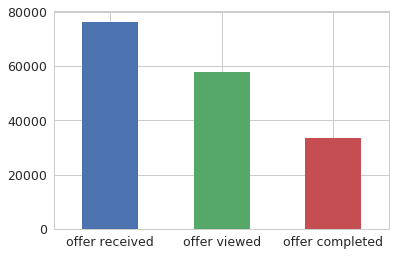

In [149]:
# plot value counts in feature offers_df
offers_df['event'].value_counts().plot(kind='bar')
plt.xticks(rotation=0)

(array([0]), <a list of 1 Text xticklabel objects>)

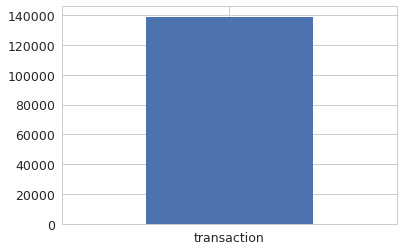

In [150]:
# plot value counts in feature offers_df
transaction_df['event'].value_counts().plot(kind='bar')
plt.xticks(rotation=0)

I am planning to have a separate dataframe which has details about customer id and Amount spent by each customer. I am calling that dataframe moneyspent.

In [151]:
# amount spent is mentioned for only data with event = transaction, so filtering that.
df_trans = transcript[transcript['event']=='transaction']
moneyspent = pd.DataFrame(data=df_trans)
moneyspent = moneyspent.drop(['value', 'event'], axis = 1)
# taing out amount from value column
moneyspent['amount'] = df_trans['value'].apply(lambda x: list(x.values())[0])
moneyspent = moneyspent.rename(columns = {'person': 'customer_id'})
moneyspent = moneyspent.reset_index(drop=True)
moneyspent.head()

,customer_id,time,amount
0,02c083884c7d45b39cc68e1314fec56c,0,0.83
1,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,34.56
2,54890f68699049c2a04d415abc25e717,0,13.23
3,b2f1cd155b864803ad8334cdf13c4bd2,0,19.51
4,fe97aa22dd3e48c8b143116a8403dd52,0,18.97


In [152]:
len(moneyspent)

138953

In [153]:
moneyspent = pd.merge(moneyspent, profile[['gender','customer_id']], how='left', on='customer_id')

# Who spends more money? male or female?

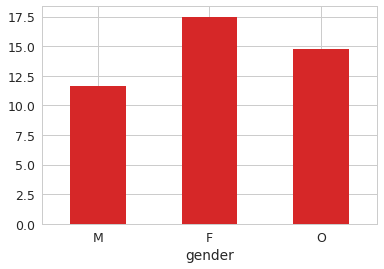

In [154]:
gender_groupby = moneyspent.groupby('gender')
gender_transactions = gender_groupby.amount.count()
gender_expense = gender_groupby.amount.sum()
(gender_expense / gender_transactions).reindex(['M', 'F','O']).plot(kind='bar', rot=0, color='tab:red');

By the filtering based on gender we see that women spend more money in general

In [155]:
# unpack information in 'value' column to separate columns
values = transcript['value'].apply(pd.Series)
values.offer_id.fillna(values['offer id'], inplace=True)
transcript = pd.concat([transcript, values], axis=1)
transcript.head()

,event,person,time,value,offer id,amount,offer_id,reward
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},2906b810c7d4411798c6938adc9daaa5,NaN,2906b810c7d4411798c6938adc9daaa5,NaN
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},fafdcd668e3743c1bb461111dcafc2a4,NaN,fafdcd668e3743c1bb461111dcafc2a4,NaN
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN


In [156]:
# calculate number of offers received per person  and save in num_offers
num_offers = transcript[transcript['event']=='offer received'].groupby('person').count().reset_index()
num_offers.rename(columns={'offer_id':'num_offers'},inplace=True)
transcript = pd.merge(transcript, num_offers[['person', 'num_offers']], how='left', on='person')
transcript.head()

,event,person,time,value,offer id,amount,offer_id,reward,num_offers
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,4.0
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,5.0
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},2906b810c7d4411798c6938adc9daaa5,NaN,2906b810c7d4411798c6938adc9daaa5,NaN,4.0
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},fafdcd668e3743c1bb461111dcafc2a4,NaN,fafdcd668e3743c1bb461111dcafc2a4,NaN,5.0
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,5.0


In [157]:
# convert event_types categorical variable into indicator variables
event_types = pd.get_dummies(transcript.event)
transcript = pd.concat([transcript, event_types], axis=1)
transcript.head()

,event,person,time,value,offer id,amount,offer_id,reward,num_offers,offer completed,offer received,offer viewed,transaction
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,4.0,0,1,0,0
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,5.0,0,1,0,0
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},2906b810c7d4411798c6938adc9daaa5,NaN,2906b810c7d4411798c6938adc9daaa5,NaN,4.0,0,1,0,0
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},fafdcd668e3743c1bb461111dcafc2a4,NaN,fafdcd668e3743c1bb461111dcafc2a4,NaN,5.0,0,1,0,0
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,5.0,0,1,0,0


In [158]:
# drop and rename columns
transcript.drop(['offer id', 'value', 'reward'], axis=1, inplace=True)
transcript.rename(columns={'person':'customer_id'},inplace=True)
transcript.head(3)

,event,customer_id,time,amount,offer_id,num_offers,offer completed,offer received,offer viewed,transaction
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,4.0,0,1,0,0
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,5.0,0,1,0,0
2,offer received,e2127556f4f64592b11af22de27a7932,0,NaN,2906b810c7d4411798c6938adc9daaa5,4.0,0,1,0,0


**Just filter based on 1 customerId to understand how the event data of each customer look like and which factors need to be addressed during the analysis**

In [159]:
transcript[transcript['customer_id']=='0009655768c64bdeb2e877511632db8f']

,event,customer_id,time,amount,offer_id,num_offers,offer completed,offer received,offer viewed,transaction
55972,offer received,0009655768c64bdeb2e877511632db8f,168,NaN,5a8bc65990b245e5a138643cd4eb9837,5.0,0,1,0,0
77705,offer viewed,0009655768c64bdeb2e877511632db8f,192,NaN,5a8bc65990b245e5a138643cd4eb9837,5.0,0,0,1,0
89291,transaction,0009655768c64bdeb2e877511632db8f,228,22.16,NaN,5.0,0,0,0,1
113605,offer received,0009655768c64bdeb2e877511632db8f,336,NaN,3f207df678b143eea3cee63160fa8bed,5.0,0,1,0,0
139992,offer viewed,0009655768c64bdeb2e877511632db8f,372,NaN,3f207df678b143eea3cee63160fa8bed,5.0,0,0,1,0
153401,offer received,0009655768c64bdeb2e877511632db8f,408,NaN,f19421c1d4aa40978ebb69ca19b0e20d,5.0,0,1,0,0
168412,transaction,0009655768c64bdeb2e877511632db8f,414,8.57,NaN,5.0,0,0,0,1
168413,offer completed,0009655768c64bdeb2e877511632db8f,414,NaN,f19421c1d4aa40978ebb69ca19b0e20d,5.0,1,0,0,0
187554,offer viewed,0009655768c64bdeb2e877511632db8f,456,NaN,f19421c1d4aa40978ebb69ca19b0e20d,5.0,0,0,1,0
204340,offer received,0009655768c64bdeb2e877511632db8f,504,NaN,fafdcd668e3743c1bb461111dcafc2a4,5.0,0,1,0,0


Combine transcript and portfolio data based on offer_id, so that we have one combined data for analysis.

In [160]:
combined = pd.merge(transcript, portfolio, how='left', on='offer_id')
combined.groupby(['offer_type', 'event']).customer_id.count()

offer_type     event          
bogo           offer completed    15669
               offer received     30499
               offer viewed       25449
discount       offer completed    17910
               offer received     30543
               offer viewed       21445
informational  offer received     15235
               offer viewed       10831
Name: customer_id, dtype: int64

In [161]:
combined.head()

,event,customer_id,time,amount,offer_id,num_offers,offer completed,offer received,offer viewed,transaction,channels,difficulty,duration,offer_type,reward
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,4.0,0,1,0,0,"[web, email, mobile]",5.0,7.0,bogo,5.0
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,5.0,0,1,0,0,"[web, email]",20.0,10.0,discount,5.0
2,offer received,e2127556f4f64592b11af22de27a7932,0,NaN,2906b810c7d4411798c6938adc9daaa5,4.0,0,1,0,0,"[web, email, mobile]",10.0,7.0,discount,2.0
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,NaN,fafdcd668e3743c1bb461111dcafc2a4,5.0,0,1,0,0,"[web, email, mobile, social]",10.0,10.0,discount,2.0
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,5.0,0,1,0,0,"[web, email, mobile, social]",10.0,5.0,bogo,10.0


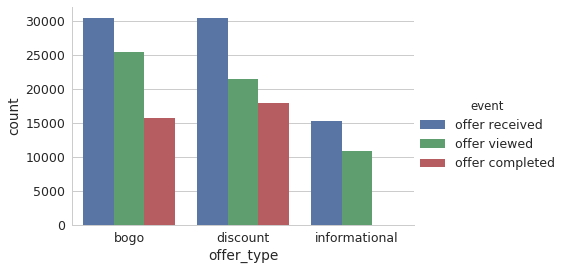

In [162]:
events_by_offer_type = sns.factorplot(data=combined[combined['event']!='transaction'], x='offer_type',
                                   kind='count', hue='event', aspect=1.5)

# Data Preparation

Inorder to give data to model and get good result, present data we have is not enough.
It is done with basic cleaning but its not prepared to give to model.

I will have a separate column to define which outcomes in the data can be classified as success cases.
As BOGO and discount offers have 'offer completed' events while informational offers have not, I prepare data for the offer types separately, starting out with BOGO and discount offers.

BOGO and Discount Offers In general, possible event paths for BOGO and discount offers are:

While successful offer is the path that reflects that an offer was successfully completed after viewing it that is what we want(desirable outcome)
both ineffective offer and unviewed offer reflect that the offer was not successful, i.e., did not lead to transactions by the customer (or to insufficient transactions).This can be treated as failure of offer.
However, it is important to keep in mind that there can also be unviewed success cases, meaning that the customer has not viewed the offer, but completed it anyways, i.e., that the customer made transactions regardless of the offer. Thus it is very much important to separate unviewed success from successful offer, so that targeting right customers can be achieved.

Ideally, Starbucks might want to target those customer groups that exhibit event path 1, while not targeting those that are most likely to follow paths 2 and 3 because those are not going to make transactions
or 4 because those make transactions anyways, so Starbucks would actually lose money by giving them discounts or BOGO offers.

In [163]:
def prepare_offer_completion(df):
    '''
    cleans dataframe for further analysis based on offer completion
    
    INPUT:
    df - the dataframe to be cleaned
    
    OUTPUT:
    combined - the cleaned dataframe
    
    ''' 
    pd.options.mode.chained_assignment = None
    
    # identify success cases in 'offer completed' rows
    offers_completed = df[['customer_id', 'event', 'time', 'offer_id', 'num_offers']].sort_values(['customer_id','time'])
    offers_completed = offers_completed[(offers_completed['event']=='offer viewed') | (offers_completed['event']=='offer completed')]
    
    
    # shift() - what this does now shifts first row to next row and put as first row as NaN. way it performs depends on condition.
    # Using this we can filter groups based on customer id and offer_id, and apply shift() to have reference offer_id in column previous_offer_id
    #this is helpful when filtering based on offer completed, so that we get success cond, where offer is completed and that is viewed.
    offers_completed['previous_offer_id'] = offers_completed.groupby(['customer_id', 'offer_id'])['offer_id'].shift()
    
    
    # if offer is completed and if it is viewed then put 1 or else 0 in success column. 
    offers_completed['success'] = np.where((offers_completed['event'] == 'offer completed')
                                           & (offers_completed['previous_offer_id'] == offers_completed['offer_id']),
                                           1, 0)
    # if offer is completed and if it is not viewed then put 1 or else 0 in unviewed success column. 
    offers_completed['unviewed_success'] = np.where((offers_completed['event'] == 'offer completed')
                                                    & (offers_completed['previous_offer_id'].isna()),
                                                    1, 0)
    offers_completed.drop(['previous_offer_id'], axis=1, inplace=True)
    
    # re-include 'offer received' rows
    received_offers = df[['customer_id', 'event', 'time', 'offer_id', 'num_offers']][df['event']=='offer received'].sort_values(['customer_id','time'])
    
    together = received_offers.append(offers_completed).sort_values(['customer_id','time'])
    together = together.sort_values(['customer_id','time'])
    
    # transmit information from 'offer completed' to corresponding 'offer received' rows
    successes = together[(together['event']=='offer received') | (together['event']=='offer completed')]
    successes['success'] = successes.groupby(['customer_id', 'offer_id'])['success'].bfill()
    successes['unviewed_success'] = successes.groupby(['customer_id', 'offer_id'])['unviewed_success'].bfill()
    result = successes[successes['event']=='offer received']
    
    # classify remaining offers as failures and fill missings
    result['failure'] = np.where((result['success'].isna()) & (result['unviewed_success'].isna()), 1, 0)
    # fill missing values with 0
    result['success'] = np.where(result['success'].isna(), 0, result['success'])
    
    result['success'] = result['success'].astype('int')
    result['unviewed_success'] = np.where(result['unviewed_success'].isna(), 0, result['unviewed_success'])
    result['unviewed_success'] = result['unviewed_success'].astype('int')
    
    # build categorical outcome column
    result['outcome'] = np.where(result['success'] == 1, 'success',
                                 np.where(result['unviewed_success'] == 1, 'unviewed success', 'failure'))

    outcome_map = {'failure': 0, 'unviewed success': 1, 'success': 2}
    result['outcome_factor'] = result['outcome'].map(outcome_map)
    
    # add customer and offer information
    combined = pd.merge(result, portfolio, how='left', on='offer_id')
    combined = pd.merge(combined, profile, how='left', on='customer_id')
    combined.drop(['event', 'became_member_on'], axis=1, inplace=True)
    
    pd.options.mode.chained_assignment = "warn"
    
    return combined

In [164]:
bogo = combined[combined['offer_type']=='bogo']
discount = combined[combined['offer_type']=='discount']
bogo_discount_notcleaned = bogo.append(discount)

In [165]:
bogo_cleaned = prepare_offer_completion(bogo)
discount_cleaned = prepare_offer_completion(discount)
bogo_discount = bogo_cleaned.append(discount_cleaned)
bogo_discount.head(10)

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


,customer_id,num_offers,offer_id,success,time,unviewed_success,failure,outcome,outcome_factor,channels,difficulty,duration,offer_type,reward,age,gender,income
0,0009655768c64bdeb2e877511632db8f,5.0,f19421c1d4aa40978ebb69ca19b0e20d,0,408,1,0,unviewed success,1,"[web, email, mobile, social]",5,5,bogo,5,33.0,M,72000.0
1,00116118485d4dfda04fdbaba9a87b5c,2.0,f19421c1d4aa40978ebb69ca19b0e20d,0,168,0,1,failure,0,"[web, email, mobile, social]",5,5,bogo,5,NaN,NaN,NaN
2,00116118485d4dfda04fdbaba9a87b5c,2.0,f19421c1d4aa40978ebb69ca19b0e20d,0,576,0,1,failure,0,"[web, email, mobile, social]",5,5,bogo,5,NaN,NaN,NaN
3,0011e0d4e6b944f998e987f904e8c1e5,5.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,504,0,0,success,2,"[web, email, mobile]",5,7,bogo,5,40.0,O,57000.0
4,0020c2b971eb4e9188eac86d93036a77,5.0,ae264e3637204a6fb9bb56bc8210ddfd,0,168,0,1,failure,0,"[email, mobile, social]",10,7,bogo,10,59.0,F,90000.0
5,0020c2b971eb4e9188eac86d93036a77,5.0,4d5c57ea9a6940dd891ad53e9dbe8da0,1,408,0,0,success,2,"[web, email, mobile, social]",10,5,bogo,10,59.0,F,90000.0
6,0020ccbbb6d84e358d3414a3ff76cffd,4.0,f19421c1d4aa40978ebb69ca19b0e20d,1,336,0,0,success,2,"[web, email, mobile, social]",5,5,bogo,5,24.0,F,60000.0
7,0020ccbbb6d84e358d3414a3ff76cffd,4.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,504,0,0,success,2,"[web, email, mobile]",5,7,bogo,5,24.0,F,60000.0
8,004b041fbfe44859945daa2c7f79ee64,3.0,f19421c1d4aa40978ebb69ca19b0e20d,1,504,0,0,success,2,"[web, email, mobile, social]",5,5,bogo,5,55.0,F,74000.0
9,004c5799adbf42868b9cff0396190900,5.0,ae264e3637204a6fb9bb56bc8210ddfd,0,336,1,0,unviewed success,1,"[email, mobile, social]",10,7,bogo,10,54.0,M,99000.0


In [166]:
def prepare_offer_info_tranx(df):
    '''
    cleans dataframe for further analysis based on transactions within validity period
    
    INPUT:
    df - the dataframe to be cleaned
    
    OUTPUT:
    temp3 - the cleaned dataframe
    
    ''' 
    temp3 = df.sort_values(['customer_id','time'])

    # calculate remaining time for offers
    temp3['duration_hrs'] = temp3.duration * 24
    
    # if offer recieved then temp3['time'] + temp3['duration_hrs'] or nan
    temp3['end_time'] = np.where(temp3['event']=='offer received', temp3['time'] + temp3['duration_hrs'], np.nan)
    temp3['end_time'] = temp3.groupby('customer_id')['end_time'].ffill()
    temp3['remaining'] = temp3['end_time'] - temp3.time


    # calculate transaction sum during offer validity period using transactions and offer viewed
    temp3_rest = temp3[(temp3['event']=='offer viewed')|(temp3['event']=='transaction')]
    uff = pd.DataFrame(temp3_rest.groupby(['customer_id'])['amount'].sum())
    uff.rename(columns={'amount':'sum'},inplace=True)
    temp3_rest_sum = pd.merge(temp3_rest, uff, how='left', on=['customer_id'])
    temp3_rest_sum['amount'] = np.where(temp3_rest_sum['event']=='offer viewed', temp3_rest_sum['sum'], temp3_rest_sum['amount'])
    temp3 = temp3[temp3['event']=='offer received'].append(temp3_rest_sum).sort_values(['customer_id','time'])
    temp3 = temp3.drop(columns=['duration_hrs', 'end_time', 'remaining', 'sum'])

    # transfer transaction sum to 'offer received' rows
    temp3 = temp3[-(temp3['event']=='transaction')]
    temp3['amount'] = temp3.groupby(['customer_id'])['amount'].shift(-1)
    temp3 = temp3[temp3['event']=='offer received']
    temp3['amount'] = temp3['amount'].fillna(0)
    
    # add success indicator
    temp3['success'] = np.where(temp3['amount']>0,1,0)
    temp3['unviewed_success'] = -99
    temp3['failure'] = -99
    temp3['outcome'] = -99
    temp3['outcome_factor'] = -99
    
    # add customer information
    temp3 = pd.merge(temp3, profile, how='left', on='customer_id')
    temp3.drop(['event'], axis=1, inplace=True)

    return temp3

In [167]:
info = combined[(combined['offer_type']=='informational') |(combined['event']=='transaction')]

In [168]:
info

,event,customer_id,time,amount,offer_id,num_offers,offer completed,offer received,offer viewed,transaction,channels,difficulty,duration,offer_type,reward
7,offer received,2eeac8d8feae4a8cad5a6af0499a211d,0,NaN,3f207df678b143eea3cee63160fa8bed,3.0,0,1,0,0,"[web, email, mobile]",0.0,4.0,informational,0.0
13,offer received,c27e0d6ab72c455a8bb66d980963de60,0,NaN,3f207df678b143eea3cee63160fa8bed,6.0,0,1,0,0,"[web, email, mobile]",0.0,4.0,informational,0.0
31,offer received,be8a5d1981a2458d90b255ddc7e0d174,0,NaN,5a8bc65990b245e5a138643cd4eb9837,5.0,0,1,0,0,"[email, mobile, social]",0.0,3.0,informational,0.0
44,offer received,a5a6ef2b78a04ddc9f374dd7c7f60bff,0,NaN,5a8bc65990b245e5a138643cd4eb9837,3.0,0,1,0,0,"[email, mobile, social]",0.0,3.0,informational,0.0
53,offer received,6e04a90a0e074496b5f229eb1f553433,0,NaN,5a8bc65990b245e5a138643cd4eb9837,5.0,0,1,0,0,"[email, mobile, social]",0.0,3.0,informational,0.0
55,offer received,a2b7a0b3487a4d779ddf4e11a034e2ee,0,NaN,5a8bc65990b245e5a138643cd4eb9837,5.0,0,1,0,0,"[email, mobile, social]",0.0,3.0,informational,0.0
56,offer received,2c5c63e5124e417b8504f76c868a4190,0,NaN,3f207df678b143eea3cee63160fa8bed,5.0,0,1,0,0,"[web, email, mobile]",0.0,4.0,informational,0.0
76,offer received,5e9c83e8ab4d4e9ca83f3256d83ca756,0,NaN,3f207df678b143eea3cee63160fa8bed,5.0,0,1,0,0,"[web, email, mobile]",0.0,4.0,informational,0.0
86,offer received,1a353048b0884fc5a0afa27677ef1e80,0,NaN,5a8bc65990b245e5a138643cd4eb9837,5.0,0,1,0,0,"[email, mobile, social]",0.0,3.0,informational,0.0
90,offer received,6747dda08bed46298c23e05b64820a3a,0,NaN,3f207df678b143eea3cee63160fa8bed,4.0,0,1,0,0,"[web, email, mobile]",0.0,4.0,informational,0.0


In [169]:
info_cleaned = prepare_offer_info_tranx(info)
info_cleaned.head(5)

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


,amount,channels,customer_id,difficulty,duration,num_offers,offer completed,offer received,offer viewed,offer_id,...,transaction,success,unviewed_success,failure,outcome,outcome_factor,age,became_member_on,gender,income
0,127.60,"[email, mobile, social]",0009655768c64bdeb2e877511632db8f,0.0,3.0,5.0,0,1,0,5a8bc65990b245e5a138643cd4eb9837,...,0,1,-99,-99,-99,-99,33.0,20170421.0,M,72000.0
1,127.60,"[web, email, mobile]",0009655768c64bdeb2e877511632db8f,0.0,4.0,5.0,0,1,0,3f207df678b143eea3cee63160fa8bed,...,0,1,-99,-99,-99,-99,33.0,20170421.0,M,72000.0
2,79.46,"[web, email, mobile]",0011e0d4e6b944f998e987f904e8c1e5,0.0,4.0,5.0,0,1,0,3f207df678b143eea3cee63160fa8bed,...,0,1,-99,-99,-99,-99,40.0,20180109.0,O,57000.0
3,79.46,"[email, mobile, social]",0011e0d4e6b944f998e987f904e8c1e5,0.0,3.0,5.0,0,1,0,5a8bc65990b245e5a138643cd4eb9837,...,0,1,-99,-99,-99,-99,40.0,20180109.0,O,57000.0
4,196.86,"[email, mobile, social]",0020c2b971eb4e9188eac86d93036a77,0.0,3.0,5.0,0,1,0,5a8bc65990b245e5a138643cd4eb9837,...,0,1,-99,-99,-99,-99,59.0,20160304.0,F,90000.0


In [170]:
info_test = info.drop(columns=['amount'])
full_data = bogo_discount.append(info_test)
full_data.head()

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


,age,channels,customer_id,difficulty,duration,event,failure,gender,income,num_offers,...,offer viewed,offer_id,offer_type,outcome,outcome_factor,reward,success,time,transaction,unviewed_success
0,33.0,"[web, email, mobile, social]",0009655768c64bdeb2e877511632db8f,5.0,5.0,NaN,0.0,M,72000.0,5.0,...,NaN,f19421c1d4aa40978ebb69ca19b0e20d,bogo,unviewed success,1.0,5.0,0.0,408,NaN,1.0
1,NaN,"[web, email, mobile, social]",00116118485d4dfda04fdbaba9a87b5c,5.0,5.0,NaN,1.0,NaN,NaN,2.0,...,NaN,f19421c1d4aa40978ebb69ca19b0e20d,bogo,failure,0.0,5.0,0.0,168,NaN,0.0
2,NaN,"[web, email, mobile, social]",00116118485d4dfda04fdbaba9a87b5c,5.0,5.0,NaN,1.0,NaN,NaN,2.0,...,NaN,f19421c1d4aa40978ebb69ca19b0e20d,bogo,failure,0.0,5.0,0.0,576,NaN,0.0
3,40.0,"[web, email, mobile]",0011e0d4e6b944f998e987f904e8c1e5,5.0,7.0,NaN,0.0,O,57000.0,5.0,...,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,success,2.0,5.0,1.0,504,NaN,0.0
4,59.0,"[email, mobile, social]",0020c2b971eb4e9188eac86d93036a77,10.0,7.0,NaN,1.0,F,90000.0,5.0,...,NaN,ae264e3637204a6fb9bb56bc8210ddfd,bogo,failure,0.0,10.0,0.0,168,NaN,0.0


In [171]:
full_data=full_data.fillna(0);

In [172]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 226061 entries, 0 to 306533
Data columns (total 22 columns):
age                 226061 non-null float64
channels            226061 non-null object
customer_id         226061 non-null object
difficulty          226061 non-null float64
duration            226061 non-null float64
event               226061 non-null object
failure             226061 non-null float64
gender              226061 non-null object
income              226061 non-null float64
num_offers          226061 non-null float64
offer completed     226061 non-null float64
offer received      226061 non-null float64
offer viewed        226061 non-null float64
offer_id            226061 non-null object
offer_type          226061 non-null object
outcome             226061 non-null object
outcome_factor      226061 non-null float64
reward              226061 non-null float64
success             226061 non-null float64
time                226061 non-null int64
transaction       

In [173]:
offer_id = full_data['offer_id'].unique()
offer_id

array(['f19421c1d4aa40978ebb69ca19b0e20d',
       '9b98b8c7a33c4b65b9aebfe6a799e6d9',
       'ae264e3637204a6fb9bb56bc8210ddfd',
       '4d5c57ea9a6940dd891ad53e9dbe8da0',
       'fafdcd668e3743c1bb461111dcafc2a4',
       '2906b810c7d4411798c6938adc9daaa5',
       '2298d6c36e964ae4a3e7e9706d1fb8c2',
       '0b1e1539f2cc45b7b9fa7c272da2e1d7',
       '3f207df678b143eea3cee63160fa8bed',
       '5a8bc65990b245e5a138643cd4eb9837', 0], dtype=object)

In [174]:
offer_dict = pd.Series(offer_id ).to_dict()
offer_dict

{0: 'f19421c1d4aa40978ebb69ca19b0e20d',
 1: '9b98b8c7a33c4b65b9aebfe6a799e6d9',
 2: 'ae264e3637204a6fb9bb56bc8210ddfd',
 3: '4d5c57ea9a6940dd891ad53e9dbe8da0',
 4: 'fafdcd668e3743c1bb461111dcafc2a4',
 5: '2906b810c7d4411798c6938adc9daaa5',
 6: '2298d6c36e964ae4a3e7e9706d1fb8c2',
 7: '0b1e1539f2cc45b7b9fa7c272da2e1d7',
 8: '3f207df678b143eea3cee63160fa8bed',
 9: '5a8bc65990b245e5a138643cd4eb9837',
 10: 0}

In [175]:
offer_dict = dict([(value, key) for key, value in offer_dict.items()]) 
offer_dict

{'f19421c1d4aa40978ebb69ca19b0e20d': 0,
 '9b98b8c7a33c4b65b9aebfe6a799e6d9': 1,
 'ae264e3637204a6fb9bb56bc8210ddfd': 2,
 '4d5c57ea9a6940dd891ad53e9dbe8da0': 3,
 'fafdcd668e3743c1bb461111dcafc2a4': 4,
 '2906b810c7d4411798c6938adc9daaa5': 5,
 '2298d6c36e964ae4a3e7e9706d1fb8c2': 6,
 '0b1e1539f2cc45b7b9fa7c272da2e1d7': 7,
 '3f207df678b143eea3cee63160fa8bed': 8,
 '5a8bc65990b245e5a138643cd4eb9837': 9,
 0: 10}

In [176]:
full_data['offer_id'] = full_data['offer_id'].map(offer_dict)
full_data.head()

,age,channels,customer_id,difficulty,duration,event,failure,gender,income,num_offers,...,offer viewed,offer_id,offer_type,outcome,outcome_factor,reward,success,time,transaction,unviewed_success
0,33.0,"[web, email, mobile, social]",0009655768c64bdeb2e877511632db8f,5.0,5.0,0,0.0,M,72000.0,5.0,...,0.0,0,bogo,unviewed success,1.0,5.0,0.0,408,0.0,1.0
1,0.0,"[web, email, mobile, social]",00116118485d4dfda04fdbaba9a87b5c,5.0,5.0,0,1.0,0,0.0,2.0,...,0.0,0,bogo,failure,0.0,5.0,0.0,168,0.0,0.0
2,0.0,"[web, email, mobile, social]",00116118485d4dfda04fdbaba9a87b5c,5.0,5.0,0,1.0,0,0.0,2.0,...,0.0,0,bogo,failure,0.0,5.0,0.0,576,0.0,0.0
3,40.0,"[web, email, mobile]",0011e0d4e6b944f998e987f904e8c1e5,5.0,7.0,0,0.0,O,57000.0,5.0,...,0.0,1,bogo,success,2.0,5.0,1.0,504,0.0,0.0
4,59.0,"[email, mobile, social]",0020c2b971eb4e9188eac86d93036a77,10.0,7.0,0,1.0,F,90000.0,5.0,...,0.0,2,bogo,failure,0.0,10.0,0.0,168,0.0,0.0


In [177]:
full_data['offer_id'] = full_data['offer_id'].replace(1, np.nan)

In [178]:
full_data.head()

,age,channels,customer_id,difficulty,duration,event,failure,gender,income,num_offers,...,offer viewed,offer_id,offer_type,outcome,outcome_factor,reward,success,time,transaction,unviewed_success
0,33.0,"[web, email, mobile, social]",0009655768c64bdeb2e877511632db8f,5.0,5.0,0,0.0,M,72000.0,5.0,...,0.0,0.0,bogo,unviewed success,1.0,5.0,0.0,408,0.0,1.0
1,0.0,"[web, email, mobile, social]",00116118485d4dfda04fdbaba9a87b5c,5.0,5.0,0,1.0,0,0.0,2.0,...,0.0,0.0,bogo,failure,0.0,5.0,0.0,168,0.0,0.0
2,0.0,"[web, email, mobile, social]",00116118485d4dfda04fdbaba9a87b5c,5.0,5.0,0,1.0,0,0.0,2.0,...,0.0,0.0,bogo,failure,0.0,5.0,0.0,576,0.0,0.0
3,40.0,"[web, email, mobile]",0011e0d4e6b944f998e987f904e8c1e5,5.0,7.0,0,0.0,O,57000.0,5.0,...,0.0,NaN,bogo,success,2.0,5.0,1.0,504,0.0,0.0
4,59.0,"[email, mobile, social]",0020c2b971eb4e9188eac86d93036a77,10.0,7.0,0,1.0,F,90000.0,5.0,...,0.0,2.0,bogo,failure,0.0,10.0,0.0,168,0.0,0.0


In [179]:
full_data['offer_id'].unique()

array([  0.,  nan,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.])

In [180]:
event_ids = full_data['event'].unique()
event_ids

array([0, 'offer received', 'offer viewed', 'transaction'], dtype=object)

In [181]:
event_dict = pd.Series(event_ids).to_dict()
event_dict

{0: 0, 1: 'offer received', 2: 'offer viewed', 3: 'transaction'}

In [182]:
event_dict = dict([(value, key) for key, value in event_dict.items()]) 
event_dict

{0: 0, 'offer received': 1, 'offer viewed': 2, 'transaction': 3}

In [183]:
#map event_ids to the encoded event ids
full_data['event_id'] = full_data['event'].map(event_dict)

In [184]:
full_data.head()

,age,channels,customer_id,difficulty,duration,event,failure,gender,income,num_offers,...,offer_id,offer_type,outcome,outcome_factor,reward,success,time,transaction,unviewed_success,event_id
0,33.0,"[web, email, mobile, social]",0009655768c64bdeb2e877511632db8f,5.0,5.0,0,0.0,M,72000.0,5.0,...,0.0,bogo,unviewed success,1.0,5.0,0.0,408,0.0,1.0,0
1,0.0,"[web, email, mobile, social]",00116118485d4dfda04fdbaba9a87b5c,5.0,5.0,0,1.0,0,0.0,2.0,...,0.0,bogo,failure,0.0,5.0,0.0,168,0.0,0.0,0
2,0.0,"[web, email, mobile, social]",00116118485d4dfda04fdbaba9a87b5c,5.0,5.0,0,1.0,0,0.0,2.0,...,0.0,bogo,failure,0.0,5.0,0.0,576,0.0,0.0,0
3,40.0,"[web, email, mobile]",0011e0d4e6b944f998e987f904e8c1e5,5.0,7.0,0,0.0,O,57000.0,5.0,...,NaN,bogo,success,2.0,5.0,1.0,504,0.0,0.0,0
4,59.0,"[email, mobile, social]",0020c2b971eb4e9188eac86d93036a77,10.0,7.0,0,1.0,F,90000.0,5.0,...,2.0,bogo,failure,0.0,10.0,0.0,168,0.0,0.0,0


In [185]:
full_data.shape

(226061, 23)

In [186]:
full_data.columns

Index(['age', 'channels', 'customer_id', 'difficulty', 'duration', 'event',
       'failure', 'gender', 'income', 'num_offers', 'offer completed',
       'offer received', 'offer viewed', 'offer_id', 'offer_type', 'outcome',
       'outcome_factor', 'reward', 'success', 'time', 'transaction',
       'unviewed_success', 'event_id'],
      dtype='object')

In [187]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 226061 entries, 0 to 306533
Data columns (total 23 columns):
age                 226061 non-null float64
channels            226061 non-null object
customer_id         226061 non-null object
difficulty          226061 non-null float64
duration            226061 non-null float64
event               226061 non-null object
failure             226061 non-null float64
gender              226061 non-null object
income              226061 non-null float64
num_offers          226061 non-null float64
offer completed     226061 non-null float64
offer received      226061 non-null float64
offer viewed        226061 non-null float64
offer_id            218384 non-null float64
offer_type          226061 non-null object
outcome             226061 non-null object
outcome_factor      226061 non-null float64
reward              226061 non-null float64
success             226061 non-null float64
time                226061 non-null int64
transaction      

# Which offer is the most successful?

In [188]:
print('The total counts of different events for BOGO offer is')
print(bogo.event.value_counts())

print('\n\nThe total counts of different events for discount offer is')
print(discount.event.value_counts())

The total counts of different events for BOGO offer is
offer received     30499
offer viewed       25449
offer completed    15669
Name: event, dtype: int64


The total counts of different events for discount offer is
offer received     30543
offer viewed       21445
offer completed    17910
Name: event, dtype: int64


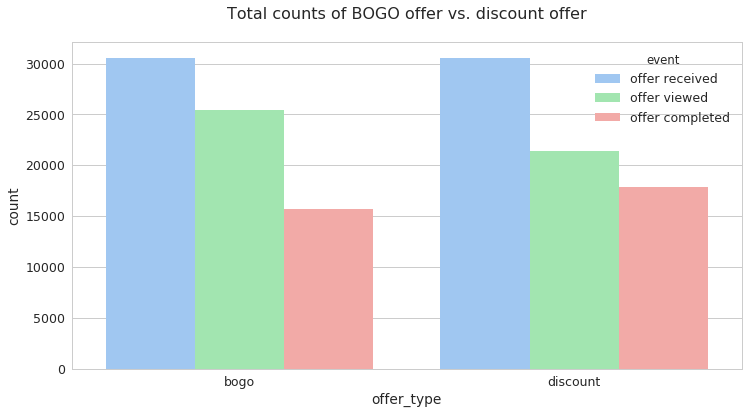

In [189]:
fig, ax = plt.subplots(figsize=(12,6))
sns.countplot(x="offer_type", hue="event", data=bogo_discount_notcleaned, palette="pastel")
plt.title("Total counts of BOGO offer vs. discount offer\n", fontsize=16);

In [190]:
def event_counts(df):
    """
    output:
    returns the counts of each individual event
    Input:
    df: dataframe
    """
    events = df['event'].unique()
    counts = []
    for event in events:
        count = len(df[df['event'] == event])
        yield count

In [191]:
#event counts of BOGO offer
bogo_received, bogo_viewed, bogo_completed = event_counts(bogo)

#event counts of discount offer
discount_received, discount_viewed, discount_completed = event_counts(discount)

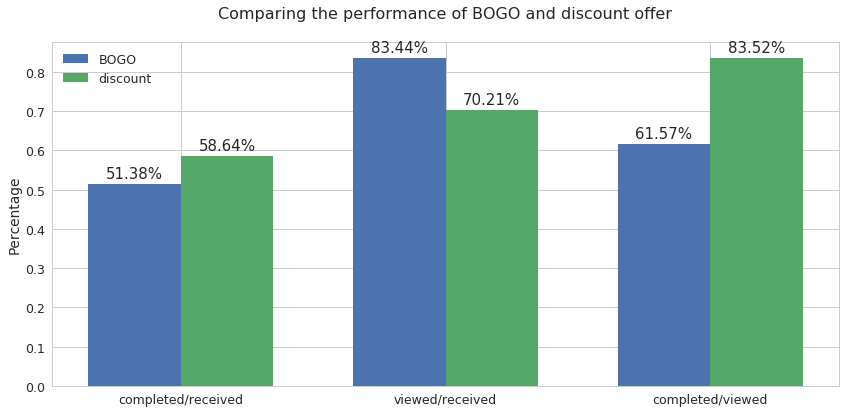

In [192]:
labels = ['completed/received', 'viewed/received', 'completed/viewed']
bogo_performance = [bogo_completed/bogo_received, bogo_viewed/bogo_received, bogo_completed/bogo_viewed]
discount_performance = [discount_completed/discount_received, discount_viewed/discount_received, discount_completed/discount_viewed]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(12,6))
rects1 = ax.bar(x - width/2, bogo_performance, width, label='BOGO')
rects2 = ax.bar(x + width/2, discount_performance, width, label='discount')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Percentage')
ax.set_title('Comparing the performance of BOGO and discount offer\n', fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}%'.format(round(height*100, 2)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

# Discount offer is more successful because

not only the absolute number of 'offer completed' is slightly higher than BOGO offer, its overall completed/received rate is also about 7% higher. However, BOGO offer has a much greater chance to be viewed or seen by customers. But turning offer received to offer completed can be done by discount offer than bogo offer.

In [193]:
pd.DataFrame(full_data.groupby(['offer_type'])['success'].mean()).reset_index().sort_values('success', ascending=False)

,offer_type,success
2,discount,0.453983
1,bogo,0.409981
0,0,0.000000
3,informational,0.000000


**It shows that discount offer has gained more success than any other offer type**

# Modelling and Prediction

Applying One-Hot Encoding to prepare the data for modelling

In [194]:
genders = {'O': 0, 'M': 1, 'F': 2}
full_data['gender'] = full_data['gender'].map(genders)

In [195]:
full_data.offer_type.value_counts()

0                138953
discount          30543
bogo              30499
informational     26066
Name: offer_type, dtype: int64

In [196]:
offers = {'bogo': 0, 'discount': 1, '0': 2}
full_data['offer_type'] = full_data['offer_type'].map(offers)

In [197]:
full_data.head()

,age,channels,customer_id,difficulty,duration,event,failure,gender,income,num_offers,...,offer_id,offer_type,outcome,outcome_factor,reward,success,time,transaction,unviewed_success,event_id
0,33.0,"[web, email, mobile, social]",0009655768c64bdeb2e877511632db8f,5.0,5.0,0,0.0,1.0,72000.0,5.0,...,0.0,0.0,unviewed success,1.0,5.0,0.0,408,0.0,1.0,0
1,0.0,"[web, email, mobile, social]",00116118485d4dfda04fdbaba9a87b5c,5.0,5.0,0,1.0,NaN,0.0,2.0,...,0.0,0.0,failure,0.0,5.0,0.0,168,0.0,0.0,0
2,0.0,"[web, email, mobile, social]",00116118485d4dfda04fdbaba9a87b5c,5.0,5.0,0,1.0,NaN,0.0,2.0,...,0.0,0.0,failure,0.0,5.0,0.0,576,0.0,0.0,0
3,40.0,"[web, email, mobile]",0011e0d4e6b944f998e987f904e8c1e5,5.0,7.0,0,0.0,0.0,57000.0,5.0,...,NaN,0.0,success,2.0,5.0,1.0,504,0.0,0.0,0
4,59.0,"[email, mobile, social]",0020c2b971eb4e9188eac86d93036a77,10.0,7.0,0,1.0,2.0,90000.0,5.0,...,2.0,0.0,failure,0.0,10.0,0.0,168,0.0,0.0,0


In [198]:
full_data.columns

Index(['age', 'channels', 'customer_id', 'difficulty', 'duration', 'event',
       'failure', 'gender', 'income', 'num_offers', 'offer completed',
       'offer received', 'offer viewed', 'offer_id', 'offer_type', 'outcome',
       'outcome_factor', 'reward', 'success', 'time', 'transaction',
       'unviewed_success', 'event_id'],
      dtype='object')

In [199]:
X = full_data.drop(['customer_id', 'event' , 'offer completed', 'offer received',
       'offer viewed', 'transaction'], axis=1)
Y = full_data['event_id']

In [200]:
X.head()

,age,channels,difficulty,duration,failure,gender,income,num_offers,offer_id,offer_type,outcome,outcome_factor,reward,success,time,unviewed_success,event_id
0,33.0,"[web, email, mobile, social]",5.0,5.0,0.0,1.0,72000.0,5.0,0.0,0.0,unviewed success,1.0,5.0,0.0,408,1.0,0
1,0.0,"[web, email, mobile, social]",5.0,5.0,1.0,NaN,0.0,2.0,0.0,0.0,failure,0.0,5.0,0.0,168,0.0,0
2,0.0,"[web, email, mobile, social]",5.0,5.0,1.0,NaN,0.0,2.0,0.0,0.0,failure,0.0,5.0,0.0,576,0.0,0
3,40.0,"[web, email, mobile]",5.0,7.0,0.0,0.0,57000.0,5.0,NaN,0.0,success,2.0,5.0,1.0,504,0.0,0
4,59.0,"[email, mobile, social]",10.0,7.0,1.0,2.0,90000.0,5.0,2.0,0.0,failure,0.0,10.0,0.0,168,0.0,0


In [201]:
Y.head()

0    0
1    0
2    0
3    0
4    0
Name: event_id, dtype: int64

In [202]:
X.shape , Y.shape

((226061, 17), (226061,))

# Feature Scaling: Standardization & Normalization

Normalization is a scaling technique in which values are shifted and rescaled so that they end up ranging between 0 and 1. It is also known as Min-Max scaling.

Standardization is another scaling technique where the values are centered around the mean with a unit standard deviation. This means that the mean of the attribute becomes zero and the resultant distribution has a unit standard deviation.

In [203]:
class_name =['offer recieved', 'offer viewed', 'transaction', 'offer completed']

In [204]:
#split the dataset into test and train sets.
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

In [205]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((158242, 17), (67819, 17), (158242,), (67819,))

In [206]:
std = StandardScaler()

In [207]:
X_train.income = std.fit_transform(X_train.income.values.reshape(-1, 1))
X_train.age = std.fit_transform(X_train.age.values.reshape(-1, 1))

X_train.reset_index(inplace=True)
X_train = X_train.drop(['index'], axis=1)

/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [208]:
X_test.income = std.transform(X_test.income.values.reshape(-1, 1))
X_test.age = std.fit_transform(X_test.age.values.reshape(-1, 1))

X_test.reset_index(inplace=True)
X_test = X_test.drop(['index'], axis=1)

/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [209]:
X_train.shape, X_test.shape

((158242, 17), (67819, 17))

Converting the pandas dataframe into numpy array .

In [210]:
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

# Model Building:

In [211]:
ann = keras.models.Sequential()

In [212]:
ann.add(keras.layers.Dense(2, input_dim=2, kernel_initializer = 'normal' ,activation='relu'))
ann.add(keras.layers.Dense(6, kernel_initializer = 'normal' ,activation='relu'))
ann.add(keras.layers.Dense(6, kernel_initializer = 'normal' ,activation='relu'))
ann.add(keras.layers.Dense(4, kernel_initializer = 'normal' ,activation = 'softmax'))

In [213]:
ann.compile(optimizer = 'adam', 
            loss = 'sparse_categorical_crossentropy', 
            metrics = ['accuracy'])

In [214]:
ann_history = ann.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=15, batch_size=100 , verbose = 2)

ValueError: Error when checking input: expected dense_1_input to have shape (None, 2) but got array with shape (158242, 17)

In [ ]:
ann.summary()       
# Summary of our model 

In [ ]:
ann.history.params

In [ ]:
pd.DataFrame(ann.history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)               # Y AXIS RANGE LIMIT 
plt.show()

In [ ]:
ann.evaluate(X_test , y_test)